# 🚀 Quickstart

In this quickstart guide, we describe how to use `deshift` to solve distributionally robust optimization (DRO) problems of the form

$$
    \min_{w \in \mathbb{R}^d} \max_{q \in \mathcal{Q}} q^\top \ell(w) - \nu D(q \Vert \mathbf{1}/n)
$$
where:
- $w$ denotes the parameters of a model (the "primal variables"),
- $q$ denotes the weights on individual training examples (the "dual varialbes"),
- $\ell: \mathbb{R}^d \rightarrow \mathbb{R}^n$ denotes a loss function for individual training examples,
- $D(\cdot \Vert \mathbf{1}/n)$ denotes a divergence (either Kullback-Leibler or $\chi^2$) between a distribution on $n$ atoms and the uniform distribution $\mathbf{1}/n = (1/n, \ldots, 1/n)$,
- $\nu \geq 0$ is a dual regularization parameter, or the "shift cost",

The package requires only a single line of additional code; we first import a constructor function that specifies our choice of ambiguity set, which is chosen to be spectral risk measures in this case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../..")
from deshift import make_spectral_risk_measure, make_superquantile_spectrum

The fundamental object required to compute the gradient of the DRO objective is a function that computes

$$
l \mapsto \operatorname{argmax}_{q \in \mathcal{Q}} q^\top l - \nu D(q \Vert \mathbf{1}_n/n)
$$
for some vector $l \in \mathbb{R}^n$. In particular, we set

$$
    \mathcal{Q} \equiv \mathcal{Q}(\sigma) = \operatorname{conv}\{\text{permutations of $\sigma$}\},
$$
where $\sigma = (\sigma_1, \ldots, \sigma_n)$ is a vector of non-negative weights that sums to one, called the *spectrum*. We call $\mathcal{Q}(\sigma)$ is the *permutahedron* associated to the vector $\sigma$. Various choices of $\sigma$ can be generated by using the `make_<spectrum_name>_spectrum` functions within the package, which return Numpy arrays with value equal to $\sigma$. Each has a risk parameter which determines the skewedness of the spectrum (which influences the size of $\mathcal{Q}(\sigma)$).

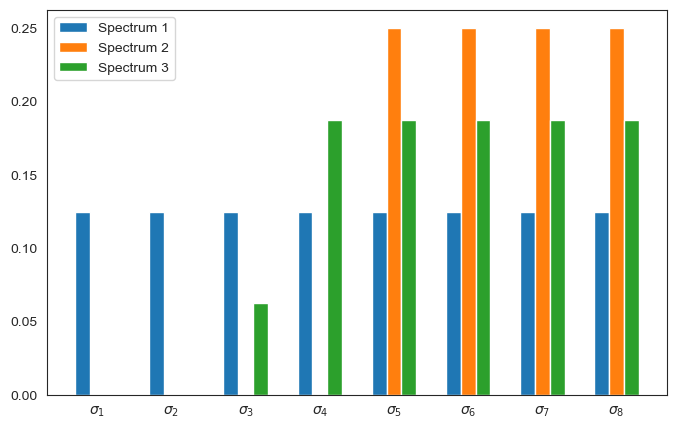

In [3]:
batch_size = 8

sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

offset = 0.2
colors = ["tab:blue", "tab:orange", "tab:green"]
x = np.arange(batch_size)
for i in range(3):
    spectrum = make_superquantile_spectrum(batch_size, 1.0 / (i + 1.))
    ax.bar(x + i * offset, spectrum, color=colors[i], width=offset, label=f"Spectrum {i + 1}")
ax.legend(loc="upper left")
ax.set_xticks(x + offset)
ax.set_xticklabels([r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$", r"$\sigma_5$", r"$\sigma_6$", r"$\sigma_7$", r"$\sigma_8$"])
plt.show()

To create the oracle that performs the maximization, we simply use the `make_spectral_risk_measure` function and specify the form of the penalty with the `penalty` parameter and the shift cost $\nu \geq 0$ with the `shift_cost` parameter. Currently, the $\chi^2$-divergence penalty is supported by using the `chi2` string and the Kullback-Leibler using the `kl` string.

In [5]:
batch_size = 10
shift_cost = 1.0
penalty = "chi2" # options: 'chi2'

# define spectrum based on the 2-extremile
spectrum = make_superquantile_spectrum(batch_size, 0.5)

# create function which computes weight on each example
compute_sample_weight = make_spectral_risk_measure(spectrum, penalty=penalty, shift_cost=shift_cost)

The result will be a function that takes in a collection of losses and returns a weight associated with each loss. As a sanity check, the sorted order of the weights should be the same as the sorted order of the losses.

In [6]:
np.random.seed(123)

losses = np.random.normal(size=(batch_size,))
weights = compute_sample_weight(losses)

print(weights[np.argsort(losses)])

tensor([-8.3267e-17, -8.3267e-17,  2.7756e-17,  2.7756e-17,  2.5156e-02,
         1.7484e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01])


As seen above, the result is a PyTorch tensor. This is made to be amenable to existing PyTorch training workflows. See the `train_fashion_mnist.ipynb` example for guidance on embedding these weights into an existing PyTorch training loop with backpropagation.